In [23]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.nn.modules.conv import Conv2d 
import torch.nn.functional as F
from torch.nn.modules.batchnorm import BatchNorm2d
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [24]:
class Net(nn.Module):
    def __init__(self):	
        super(Net, self).__init__()
        self.conv1=Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)#125*125
        
        self.conv2=Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)#61*61
        
        self.conv3=Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2),bias=False)#30*30
        
        self.conv4=Conv2d(256, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)#14*14
        
        self.conv5=Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)#12*12
        
        self.conv6=Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)#10*10
        
        self.conv7=Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)#8*8
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x=self.conv2(x)
        x = F.relu(x)
        
        x=self.conv3(x)
        x = F.relu(x)
        
        x=self.conv4(x)
        x = F.relu(x)
        
        x=self.conv5(x)
        x = F.relu(x)
        
        x=self.conv6(x)
        x = F.relu(x)
                
        x=self.conv7(x)
        return x

In [25]:
model = Net() 
model=model.to(device)
model

Net(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv7): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
)

In [26]:
shapeness1=np.load('/home/chase/Boyka/Lyu/data/shapeness/origin/rainfall_img256_sharpness1_unit8.npz')
data=shapeness1['data'][:,-1]
label=shapeness1['rainfall']
data=np.expand_dims(data,axis=1)
data=torch.FloatTensor(data)
print(label.shape)
label=np.expand_dims(label,axis=1)
label=torch.FloatTensor(label)
train_x=data[:-20]
test_x=data[-20:]
train_y=label[:-20]
test_y=label[-20:]
print(data.shape,label.shape)

(100, 8, 8)
torch.Size([100, 1, 256, 256]) torch.Size([100, 1, 8, 8])


In [27]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [28]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    
    history = []
    best_error = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_error = 0.0
        valid_loss = 0.0
        valid_error = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += torch.mean(loss).item() 
            
            train_error+=torch.mean(torch.abs(outputs-labels)).item()
 
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                valid_loss += torch.mean(loss).item() 
                
                valid_error+=torch.mean(torch.abs(outputs-labels)).item()
 
 
        avg_train_loss = train_loss/train_data_size
        avg_train_error = train_error/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_error = valid_error/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_error, avg_valid_error])
 
        if best_error > avg_valid_error:
            best_error = avg_valid_error
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Training: Loss: {:.4f}, MAE: {:.4f}, \nValidation: Loss: {:.4f}, MAE: {:.4f}, \nTime: {:.4f}s".format(avg_train_loss, avg_train_error, avg_valid_loss, avg_valid_error, epoch_end-epoch_start
        ))
        print("Best Error for validation : {:.4f} at epoch {:03d}".format(best_error, best_epoch))
        if epoch%20==0:
            torch.save(model, 'models/'+'rivers_model_'+str(epoch+1)+'.pt')
    return model, history


In [32]:
loss_func=nn.MSELoss()
num_epochs=500
optimizer = optim.Adam(model.parameters())


trained_model, history = train_and_valid(model, loss_func, optimizer, num_epochs)
torch.save(trained_model, 'models/'+'best_model.pt')
 


Epoch: 1/500
Training: Loss: 1.8330, MAE: 0.9460, 
Validation: Loss: 0.1618, MAE: 0.3292, 
Time: 0.4865s
Best Error for validation : 0.3292 at epoch 001
Epoch: 2/500
Training: Loss: 0.2523, MAE: 0.4219, 
Validation: Loss: 0.3144, MAE: 0.4855, 
Time: 0.4861s
Best Error for validation : 0.3292 at epoch 001
Epoch: 3/500
Training: Loss: 0.3028, MAE: 0.4706, 
Validation: Loss: 0.1351, MAE: 0.3035, 
Time: 0.4842s
Best Error for validation : 0.3035 at epoch 003
Epoch: 4/500
Training: Loss: 0.1245, MAE: 0.2933, 
Validation: Loss: 0.0832, MAE: 0.2475, 
Time: 0.4844s
Best Error for validation : 0.2475 at epoch 004
Epoch: 5/500
Training: Loss: 0.0940, MAE: 0.2605, 
Validation: Loss: 0.0810, MAE: 0.2445, 
Time: 0.4841s
Best Error for validation : 0.2445 at epoch 005
Epoch: 6/500
Training: Loss: 0.0868, MAE: 0.2520, 
Validation: Loss: 0.0817, MAE: 0.2438, 
Time: 0.4876s
Best Error for validation : 0.2438 at epoch 006
Epoch: 7/500
Training: Loss: 0.0849, MAE: 0.2508, 
Validation: Loss: 0.0817, MAE: 

Training: Loss: 0.0560, MAE: 0.1971, 
Validation: Loss: 0.1024, MAE: 0.2657, 
Time: 0.4806s
Best Error for validation : 0.2424 at epoch 017
Epoch: 56/500
Training: Loss: 0.0550, MAE: 0.1943, 
Validation: Loss: 0.1036, MAE: 0.2666, 
Time: 0.4819s
Best Error for validation : 0.2424 at epoch 017
Epoch: 57/500
Training: Loss: 0.0543, MAE: 0.1933, 
Validation: Loss: 0.1036, MAE: 0.2667, 
Time: 0.4856s
Best Error for validation : 0.2424 at epoch 017
Epoch: 58/500
Training: Loss: 0.0530, MAE: 0.1899, 
Validation: Loss: 0.1047, MAE: 0.2677, 
Time: 0.4845s
Best Error for validation : 0.2424 at epoch 017
Epoch: 59/500
Training: Loss: 0.0513, MAE: 0.1870, 
Validation: Loss: 0.1066, MAE: 0.2702, 
Time: 0.4815s
Best Error for validation : 0.2424 at epoch 017
Epoch: 60/500
Training: Loss: 0.0510, MAE: 0.1856, 
Validation: Loss: 0.1065, MAE: 0.2702, 
Time: 0.4867s
Best Error for validation : 0.2424 at epoch 017
Epoch: 61/500
Training: Loss: 0.0496, MAE: 0.1829, 
Validation: Loss: 0.1097, MAE: 0.2730,

Training: Loss: 0.0145, MAE: 0.0941, 
Validation: Loss: 0.1634, MAE: 0.3251, 
Time: 0.4863s
Best Error for validation : 0.2424 at epoch 017
Epoch: 110/500
Training: Loss: 0.0141, MAE: 0.0927, 
Validation: Loss: 0.1644, MAE: 0.3263, 
Time: 0.4824s
Best Error for validation : 0.2424 at epoch 017
Epoch: 111/500
Training: Loss: 0.0136, MAE: 0.0909, 
Validation: Loss: 0.1666, MAE: 0.3283, 
Time: 0.4831s
Best Error for validation : 0.2424 at epoch 017
Epoch: 112/500
Training: Loss: 0.0134, MAE: 0.0898, 
Validation: Loss: 0.1661, MAE: 0.3278, 
Time: 0.4862s
Best Error for validation : 0.2424 at epoch 017
Epoch: 113/500
Training: Loss: 0.0126, MAE: 0.0873, 
Validation: Loss: 0.1674, MAE: 0.3284, 
Time: 0.4822s
Best Error for validation : 0.2424 at epoch 017
Epoch: 114/500
Training: Loss: 0.0133, MAE: 0.0895, 
Validation: Loss: 0.1672, MAE: 0.3278, 
Time: 0.4865s
Best Error for validation : 0.2424 at epoch 017
Epoch: 115/500
Training: Loss: 0.0140, MAE: 0.0921, 
Validation: Loss: 0.1674, MAE: 0

Training: Loss: 0.0054, MAE: 0.0560, 
Validation: Loss: 0.1956, MAE: 0.3568, 
Time: 0.4840s
Best Error for validation : 0.2424 at epoch 017
Epoch: 163/500
Training: Loss: 0.0054, MAE: 0.0564, 
Validation: Loss: 0.1959, MAE: 0.3570, 
Time: 0.4832s
Best Error for validation : 0.2424 at epoch 017
Epoch: 164/500
Training: Loss: 0.0049, MAE: 0.0544, 
Validation: Loss: 0.1947, MAE: 0.3565, 
Time: 0.4845s
Best Error for validation : 0.2424 at epoch 017
Epoch: 165/500
Training: Loss: 0.0049, MAE: 0.0535, 
Validation: Loss: 0.1943, MAE: 0.3554, 
Time: 0.4824s
Best Error for validation : 0.2424 at epoch 017
Epoch: 166/500
Training: Loss: 0.0045, MAE: 0.0512, 
Validation: Loss: 0.1985, MAE: 0.3592, 
Time: 0.4844s
Best Error for validation : 0.2424 at epoch 017
Epoch: 167/500
Training: Loss: 0.0043, MAE: 0.0499, 
Validation: Loss: 0.1953, MAE: 0.3563, 
Time: 0.4849s
Best Error for validation : 0.2424 at epoch 017
Epoch: 168/500
Training: Loss: 0.0043, MAE: 0.0497, 
Validation: Loss: 0.1978, MAE: 0

Training: Loss: 0.0022, MAE: 0.0356, 
Validation: Loss: 0.2073, MAE: 0.3679, 
Time: 0.4891s
Best Error for validation : 0.2424 at epoch 017
Epoch: 216/500
Training: Loss: 0.0022, MAE: 0.0362, 
Validation: Loss: 0.2102, MAE: 0.3697, 
Time: 0.4827s
Best Error for validation : 0.2424 at epoch 017
Epoch: 217/500
Training: Loss: 0.0021, MAE: 0.0360, 
Validation: Loss: 0.2100, MAE: 0.3701, 
Time: 0.4812s
Best Error for validation : 0.2424 at epoch 017
Epoch: 218/500
Training: Loss: 0.0019, MAE: 0.0338, 
Validation: Loss: 0.2091, MAE: 0.3687, 
Time: 0.4798s
Best Error for validation : 0.2424 at epoch 017
Epoch: 219/500
Training: Loss: 0.0019, MAE: 0.0336, 
Validation: Loss: 0.2131, MAE: 0.3731, 
Time: 0.4833s
Best Error for validation : 0.2424 at epoch 017
Epoch: 220/500
Training: Loss: 0.0019, MAE: 0.0332, 
Validation: Loss: 0.2085, MAE: 0.3684, 
Time: 0.4868s
Best Error for validation : 0.2424 at epoch 017
Epoch: 221/500
Training: Loss: 0.0020, MAE: 0.0348, 
Validation: Loss: 0.2137, MAE: 0

Training: Loss: 0.0011, MAE: 0.0253, 
Validation: Loss: 0.2179, MAE: 0.3772, 
Time: 0.4873s
Best Error for validation : 0.2424 at epoch 017
Epoch: 269/500
Training: Loss: 0.0009, MAE: 0.0236, 
Validation: Loss: 0.2200, MAE: 0.3786, 
Time: 0.4883s
Best Error for validation : 0.2424 at epoch 017
Epoch: 270/500
Training: Loss: 0.0009, MAE: 0.0230, 
Validation: Loss: 0.2202, MAE: 0.3794, 
Time: 0.4923s
Best Error for validation : 0.2424 at epoch 017
Epoch: 271/500
Training: Loss: 0.0009, MAE: 0.0227, 
Validation: Loss: 0.2204, MAE: 0.3794, 
Time: 0.4895s
Best Error for validation : 0.2424 at epoch 017
Epoch: 272/500
Training: Loss: 0.0009, MAE: 0.0235, 
Validation: Loss: 0.2166, MAE: 0.3760, 
Time: 0.4874s
Best Error for validation : 0.2424 at epoch 017
Epoch: 273/500
Training: Loss: 0.0008, MAE: 0.0219, 
Validation: Loss: 0.2203, MAE: 0.3786, 
Time: 0.4839s
Best Error for validation : 0.2424 at epoch 017
Epoch: 274/500
Training: Loss: 0.0009, MAE: 0.0233, 
Validation: Loss: 0.2200, MAE: 0

Training: Loss: 0.0008, MAE: 0.0220, 
Validation: Loss: 0.2215, MAE: 0.3805, 
Time: 0.4808s
Best Error for validation : 0.2424 at epoch 017
Epoch: 322/500
Training: Loss: 0.0007, MAE: 0.0209, 
Validation: Loss: 0.2196, MAE: 0.3781, 
Time: 0.4875s
Best Error for validation : 0.2424 at epoch 017
Epoch: 323/500
Training: Loss: 0.0006, MAE: 0.0198, 
Validation: Loss: 0.2229, MAE: 0.3807, 
Time: 0.4844s
Best Error for validation : 0.2424 at epoch 017
Epoch: 324/500
Training: Loss: 0.0007, MAE: 0.0205, 
Validation: Loss: 0.2197, MAE: 0.3785, 
Time: 0.4865s
Best Error for validation : 0.2424 at epoch 017
Epoch: 325/500
Training: Loss: 0.0006, MAE: 0.0191, 
Validation: Loss: 0.2228, MAE: 0.3809, 
Time: 0.4848s
Best Error for validation : 0.2424 at epoch 017
Epoch: 326/500
Training: Loss: 0.0005, MAE: 0.0182, 
Validation: Loss: 0.2211, MAE: 0.3796, 
Time: 0.4827s
Best Error for validation : 0.2424 at epoch 017
Epoch: 327/500
Training: Loss: 0.0006, MAE: 0.0199, 
Validation: Loss: 0.2228, MAE: 0

Training: Loss: 0.0004, MAE: 0.0158, 
Validation: Loss: 0.2219, MAE: 0.3807, 
Time: 0.4871s
Best Error for validation : 0.2424 at epoch 017
Epoch: 375/500
Training: Loss: 0.0003, MAE: 0.0145, 
Validation: Loss: 0.2248, MAE: 0.3826, 
Time: 0.4836s
Best Error for validation : 0.2424 at epoch 017
Epoch: 376/500
Training: Loss: 0.0004, MAE: 0.0150, 
Validation: Loss: 0.2231, MAE: 0.3811, 
Time: 0.4811s
Best Error for validation : 0.2424 at epoch 017
Epoch: 377/500
Training: Loss: 0.0003, MAE: 0.0144, 
Validation: Loss: 0.2217, MAE: 0.3797, 
Time: 0.4828s
Best Error for validation : 0.2424 at epoch 017
Epoch: 378/500
Training: Loss: 0.0003, MAE: 0.0143, 
Validation: Loss: 0.2228, MAE: 0.3810, 
Time: 0.4857s
Best Error for validation : 0.2424 at epoch 017
Epoch: 379/500
Training: Loss: 0.0003, MAE: 0.0139, 
Validation: Loss: 0.2233, MAE: 0.3816, 
Time: 0.4830s
Best Error for validation : 0.2424 at epoch 017
Epoch: 380/500
Training: Loss: 0.0003, MAE: 0.0135, 
Validation: Loss: 0.2239, MAE: 0

Training: Loss: 0.0012, MAE: 0.0274, 
Validation: Loss: 0.2188, MAE: 0.3777, 
Time: 0.4850s
Best Error for validation : 0.2424 at epoch 017
Epoch: 428/500
Training: Loss: 0.0011, MAE: 0.0261, 
Validation: Loss: 0.2197, MAE: 0.3785, 
Time: 0.4850s
Best Error for validation : 0.2424 at epoch 017
Epoch: 429/500
Training: Loss: 0.0010, MAE: 0.0252, 
Validation: Loss: 0.2196, MAE: 0.3775, 
Time: 0.4846s
Best Error for validation : 0.2424 at epoch 017
Epoch: 430/500
Training: Loss: 0.0009, MAE: 0.0239, 
Validation: Loss: 0.2197, MAE: 0.3780, 
Time: 0.4842s
Best Error for validation : 0.2424 at epoch 017
Epoch: 431/500
Training: Loss: 0.0008, MAE: 0.0220, 
Validation: Loss: 0.2193, MAE: 0.3780, 
Time: 0.4822s
Best Error for validation : 0.2424 at epoch 017
Epoch: 432/500
Training: Loss: 0.0009, MAE: 0.0237, 
Validation: Loss: 0.2202, MAE: 0.3789, 
Time: 0.4849s
Best Error for validation : 0.2424 at epoch 017
Epoch: 433/500
Training: Loss: 0.0009, MAE: 0.0231, 
Validation: Loss: 0.2183, MAE: 0

Training: Loss: 0.0003, MAE: 0.0143, 
Validation: Loss: 0.2181, MAE: 0.3762, 
Time: 0.4847s
Best Error for validation : 0.2424 at epoch 017
Epoch: 481/500
Training: Loss: 0.0005, MAE: 0.0171, 
Validation: Loss: 0.2175, MAE: 0.3765, 
Time: 0.4828s
Best Error for validation : 0.2424 at epoch 017
Epoch: 482/500
Training: Loss: 0.0003, MAE: 0.0145, 
Validation: Loss: 0.2208, MAE: 0.3792, 
Time: 0.4853s
Best Error for validation : 0.2424 at epoch 017
Epoch: 483/500
Training: Loss: 0.0004, MAE: 0.0148, 
Validation: Loss: 0.2175, MAE: 0.3762, 
Time: 0.4843s
Best Error for validation : 0.2424 at epoch 017
Epoch: 484/500
Training: Loss: 0.0002, MAE: 0.0119, 
Validation: Loss: 0.2180, MAE: 0.3767, 
Time: 0.4849s
Best Error for validation : 0.2424 at epoch 017
Epoch: 485/500
Training: Loss: 0.0003, MAE: 0.0127, 
Validation: Loss: 0.2199, MAE: 0.3782, 
Time: 0.4844s
Best Error for validation : 0.2424 at epoch 017
Epoch: 486/500
Training: Loss: 0.0002, MAE: 0.0113, 
Validation: Loss: 0.2195, MAE: 0

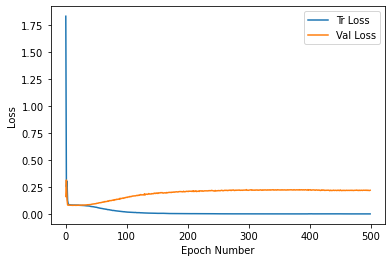

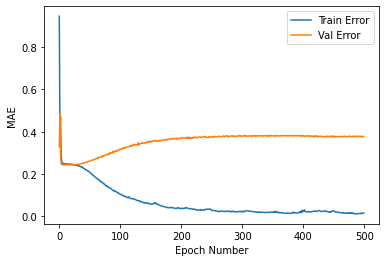

In [33]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig('loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Train Error', 'Val Error'])
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
# plt.ylim(0, 1)
plt.savefig('error_curve.png')
plt.show()